<a href="https://colab.research.google.com/github/ykitaguchi77/ImageProcessing/blob/master/Eye_crop1.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#顔の画像から目を検出して切り抜くスクリプト
・Haarcascade_eyeを使用<br>
・目が検出できないものはskipする<br>
・検出された目周囲の画像を縦横とも1.1倍の幅で切り抜く
・切り取った画像を250px*250pxにresizeする<br>
・対応表をCSV形式で出力（連番、左右、元フォルダ、元画像名）

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import csv
from random import randint
from time import sleep
import numpy as np

import glob
import random
from PIL import Image
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode

#Google colabをマウント

In [4]:
'''
・dlibを用いて目を切り抜く
・横幅を2倍、縦幅を上に2倍にして画像を切り取る（目の全幅、眉毛が含まれるように）
'''

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#元画像フォルダ
in_path = '/content/drive/My Drive/Deep_learning/eyelid_images/in'

#保存先フォルダ
out_path = '/content/drive/My Drive/Deep_learning/eyelid_images/out2'

#CSVファイルのフォルダ
csv_path = '/content/drive/My Drive/Deep_learning/eyelid_images/eyelid_images2.csv'


#Haarcascadeを指定

In [6]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'

# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

#画像を切り抜いて連番で出力、対応表出力
12時間で60000枚を処理するのは不可能（1秒間に3枚として12000枚 =フォルダ1600個ぐらいが限界）<br>
→1回のセッションでフォルダ1000個ずつを処理することとする

In [7]:
#処理するDirectoryの設定
directory = os.listdir(in_path)
print(len(directory))

#ここにフォルダ番号を記載する (ex. [0:999])
processing_directory = directory[0:999]
#print(processing_directory)

8196


In [ ]:
#処理時間の計測
start = time.time()

with open(csv_path, 'a', newline='') as f:  #a:追記モード
        writer = csv.writer(f)
        fieldnames = ['Number', 'Folder', 'FileName']       
        writer.writerow(['Folder', 'Image_num', 'side (R:0, L:1)', 'ImageName', 'Number'])  #header
        
        k=0
        for i in processing_directory:  #フォルダ数の分だけ
              file = os.listdir(in_path + '/' + i)
              k+=1
              l=0
              for j in file:
                    l+=1
                    print(str(l))
                    print('')
                    img = cv2.imread(in_path + '/' + i + '/' + j) 
                    img2 = img.copy()

                    # 画像グレースケール化
                    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                    #300pix以上のもので目に見えるものを抽出
                    eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
                    print('image path = '+ in_path + '/' + i + '/' + j )
                    
                    # 眼検出判定
                    if len(eye_list) >= 1:
                        print('目が' + str(len(eye_list)) +'個検出されました')
                        pass
                    else:
                        print("no eye detected")
                        break

                    #画像の切り抜きと保存（連番にする）
                    
                    m=0
                    for (ex, ey, ew, eh) in eye_list:
                        m+=1
                        #print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
                        
                        try:
                          cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
                          
                          #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
                          top = max(0, ey-eh)
                          bottom = min(grayscale_img.shape[0], int(ey + eh*3/2))
                          left = max(0,int(ex-ew/2))
                          right = min(grayscale_img.shape[1], int(ex + ew*3/2))

                          img_cropped = img[top: bottom,left:right]
                          height, width = img_cropped.shape[:2]

                          img_background = np.zeros((2*ew,2*eh,3), dtype = np.uint8)
                          #img_background[0: bottom-top, 0: right-left] = img_cropped 
                          img_background[0: height, 0: width] = img_cropped 
                          img_resized = cv2.resize(img_background,(1000,1000)) #1辺250pixにresize 
                          #x, y = random.randint(0,27), random.randint(0,27) #ランダムな位置で224pixに切り取る
                          #img_randcrop = img_resized[y: y+223, x: x+223]
                        except:
                          print('crop error')

                        if ex <= 600:
                            side = 0 #600ピクセル目より左にあるのは右眼
                        else:
                            side = 1 #600ピクセル目より右にあるのは左眼
                        

                        print("processing "+str(l)+"th image in "+str(m)+ "th subject")
                        '''
                        print(out_path + '/' +str(i)+'-' + str(l) + '-' + str(side)+ '.jpg')
                        '''

                        #保存する際のよくわからないエラーをskipする
                        try:
                            cv2.imwrite(out_path + '/'+str(i)+'-' + str(l) + '-' + str(side)+ '.jpg', img_resized)
                            #対応表の作成
                            writer.writerow([str(i), str(l),side, str(j), str(k+1)])
                            k+=1
                        except:
                            print('csv writing error')               

print('Process done!!')
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")


crop error
processing 1th image in 2th subject
1

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/7222/20080422144512_眼位_O_-1_ad2f4b6e0eec7fa156284a81609dde8d1a04571209d33d3641950f7f8e731258.JPG
no eye detected
1

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/7225/20150220120028_眼位_O_0_42b8c4b4b9b94b93e0068e12b4da5c69ddab1857d10e51502907dd2c720282d7.jpg
目が2個検出されました
crop error
processing 1th image in 1th subject
crop error
processing 1th image in 2th subject
1

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/7224/20160817102727_眼位_O_0_59ebe7d6e489546ababa1a87075b79ffcc0cebf38d07691ef96e87dc8524c804.jpg
目が2個検出されました
crop error
processing 1th image in 1th subject
processing 1th image in 2th subject
2

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/7224/20170222095339_眼位_O_0_4e6399cceb21ee22e40bd9f32f1f8354eb03360399cedac969ae128b01f21255.jpg
目が2個検出されました
crop error
processing 2th image in 1th subject
crop err

#切り取られた図を表示してみる

['7205-1-1.jpg', '7213-7-0.jpg', '7213-5-0.jpg', '7213-7-1.jpg', '7213-6-0.jpg', '7213-5-1.jpg', '7213-4-1.jpg', '7213-4-0.jpg', '7213-2-1.jpg', '7213-3-1.jpg', '7213-3-0.jpg', '7213-1-0.jpg', '7213-1-1.jpg', '7213-2-0.jpg', '7211-1-0.jpg', '7213-8-1.jpg', '7213-8-0.jpg', '7211-1-1.jpg', '7205-1-0.jpg']


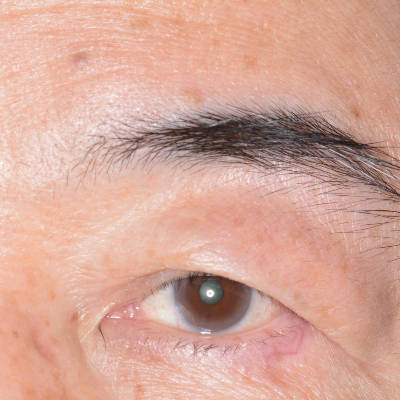

In [ ]:
img_list = os.listdir(out_path)
print(img_list)
img = cv2.imread(out_path + '/'+img_list[0])


#アスペクト比を維持したまま横を400pixelに縮小する
def scale_to_width(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale)
dst = scale_to_width(img, 400)

#図を表示する
cv2_imshow(dst)